In [25]:
#Load Data
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.linear_model import LogisticRegression

math_attrs = pd.read_csv("https://raw.githubusercontent.com/dieulien/datamining/master/b_data_math.csv", sep = ',')
math_labels= pd.read_csv("https://raw.githubusercontent.com/dieulien/datamining/master/b_categorized_math_result.csv", sep = ',',header=None)
math_attrs = math_attrs.iloc[:,1:].values
math_labels = math_labels.iloc[:,1:].values

#math_labels = math_labels.flatten()

#train-test split for drawing curve, visulization of tree etc.
math_attrs_train, math_attrs_test, math_labels_train, math_labels_test = train_test_split(math_attrs, math_labels, test_size=0.33, random_state=42)


models = ["KNN", "Naive-Bayes","Decision Tree", "Logistic Regression", "SVM"]
cross_val_scores = []


In [26]:
# KNN
def find_best_k(attrs, labels):
    score_list = []
    score_mean_list = []
    k_list = []
    optimal_k = 1

    for i in range(1,31):
        knn = KNeighborsClassifier(n_neighbors = i, metric="euclidean")
        scores = cross_val_score(knn, attrs, labels, scoring = 'f1', cv = 10)
        mean = scores.mean()
        score_list.append(scores)
        score_mean_list.append(mean)
        k_list.append(i)
        if score_mean_list[i-1] > score_mean_list[optimal_k - 1]:
            optimal_k = i

    score_df = pd.DataFrame(score_list).transpose()
    score_df.columns = [k_list]

    return optimal_k

optimal_k = find_best_k(math_attrs, math_labels)

knn = KNeighborsClassifier(n_neighbors = optimal_k, metric="euclidean")
scores = cross_val_score(knn, math_attrs, math_labels, scoring = 'f1', cv = 10)
score = scores.mean()
cross_val_scores.append(score)

print("optimal k is: " + str(optimal_k))
print("Cross Validation Score: " + str(score))

optimal k is: 1
Cross Validation Score: 0.4247615523046558


In [27]:
# Naive-Bayes
gau = GaussianNB()
scores = cross_val_score(gau, math_attrs, math_labels, scoring = 'f1', cv = 10)
score = scores.mean()
cross_val_scores.append(score)

print("Cross Validation Score: " + str(score))

Cross Validation Score: 0.460219471899455


In [28]:
# Decision Tree
def find_best_depth(attrs, labels):
    scores_tr = []
    scores_mean_tr = []
    optimal_depth = 1
    depth_values = []
    for d in range(1, 31):
        tr = tree.DecisionTreeClassifier(max_depth = d)
        cross_score_tr = cross_val_score(tr, attrs, labels, cv=10, scoring='f1')
        scores_tr.append(cross_score_tr)
        scores_mean_tr.append(cross_score_tr.mean())
        depth_values.append(d)
        if scores_mean_tr[d-1] > scores_mean_tr[optimal_depth-1]:
            optimal_depth = d
    return optimal_depth

optimal_depth = find_best_depth(math_attrs, math_labels)

tr = tree.DecisionTreeClassifier(max_depth = optimal_depth)
cross_score_tr = cross_val_score(tr, math_attrs, math_labels, cv=10, scoring='f1')
score_mean_tr = cross_score_tr.mean()
cross_val_scores.append(score_mean_tr)
score_mean_tr

print("optimal depth is: " + str(optimal_depth))
print("Cross Validation Score: " + str(score_mean_tr))

optimal depth is: 18
Cross Validation Score: 0.3262966914810993


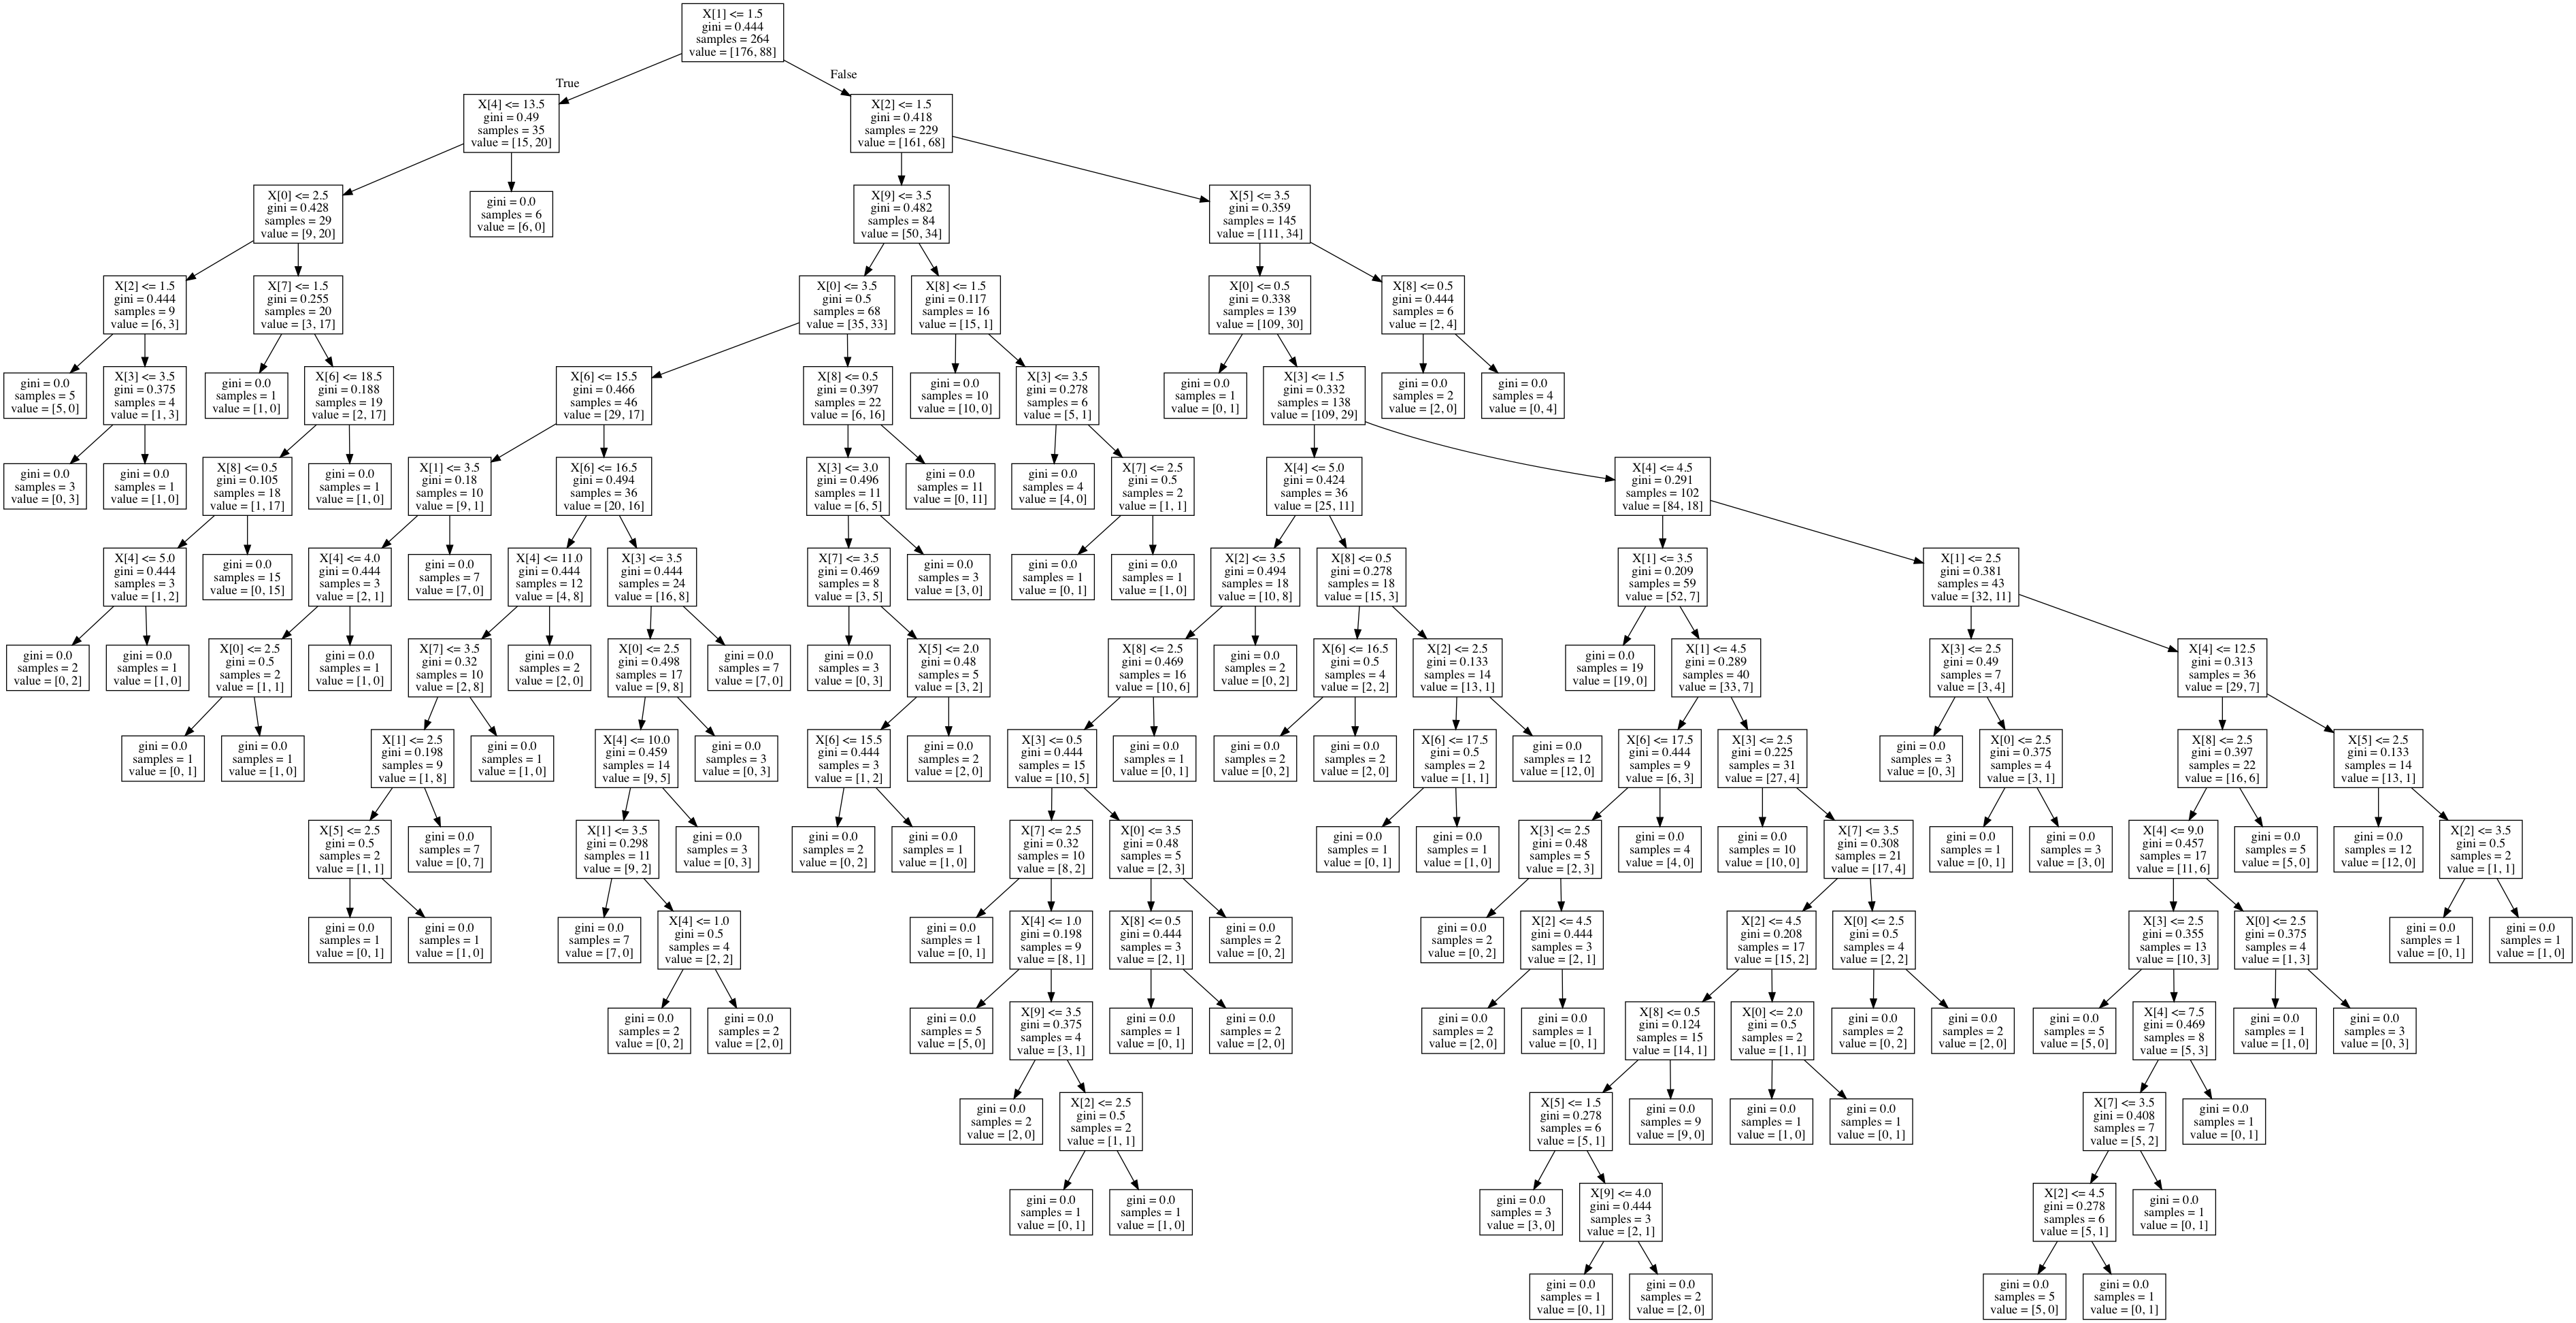

In [29]:
# show result in graph -- decision tree visualization
from IPython.display import Image 
from graphviz import Graph
import graphviz
import pydotplus

dec_tr = tree.DecisionTreeClassifier(max_depth = optimal_depth)
dec_tr.fit(math_attrs_train, math_labels_train)
tree_graphviz = tree.export_graphviz(dec_tr, out_file=None)  

tree_graph = pydotplus.graph_from_dot_data(tree_graphviz)
Image(tree_graph.create_png())

In [30]:
#Logistic Regression
log_R = LogisticRegression()

cross_score_log = cross_val_score(log_R, math_attrs, math_labels, cv=10, scoring='f1')
scores_mean = cross_score_log.mean()
cross_val_scores.append(scores_mean)

print("Cross Validation Score: " + str(scores_mean))

Cross Validation Score: 0.32242577597840755


In [31]:
#SVM

#optimizing parameters for SVM
def find_opt_svm(attrs, labels):
    best_lam = 1
    best_gam = 1
    best_acc = -1
    
    for Lambda in [0.0001, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 100.0]:
        for Gamma in [0.0001, 0.01, 0.1, 1.0, 10.0, 1000.0]:
            
            mysvm = svm.SVC(probability=True, C=1/Lambda, gamma=Gamma)        
            cross_score = cross_val_score(mysvm, attrs, labels, cv=10, scoring='f1')
            acc = cross_score.mean()
            
            if (acc > best_acc):
                best_lam = Lambda
                best_gam = Gamma
                best_acc = acc
    
    return best_lam, best_gam
                    
lam, gam = find_opt_svm(math_attrs, math_labels)

mysvm = svm.SVC(C = 1 / lam, gamma=gam,probability=True)
scores = cross_val_score(mysvm, math_attrs, math_labels, scoring = 'f1_macro', cv = 10)
score = scores.mean()
cross_val_scores.append(score)
score

print("optimal C is: " + str(1/lam))
print("optimal Gamma is: " + str(gam))
print("Cross Validation Score: " + str(score))

optimal C is: 33.333333333333336
optimal Gamma is: 0.01
Cross Validation Score: 0.6158804216416474


In [10]:
cross_val_scores.reverse()

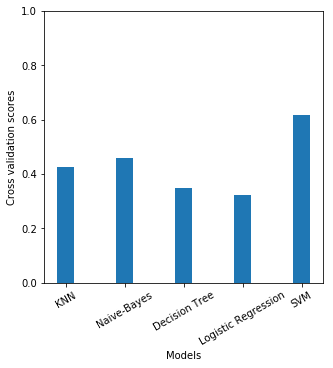

[0.4247615523046558,
 0.460219471899455,
 0.3493658091589126,
 0.32242577597840755,
 0.6158804216416474]

In [11]:
#cross_val_scores = cross_val_scores[::-1]
index = np.arange(len(models))
plt.figure(figsize = (5,5))
plt.bar(index, cross_val_scores ,width = 0.3)
plt.xlabel('Models', fontsize=10)
plt.ylim(0.0, 1.0)
plt.ylabel('Cross validation scores', fontsize=10)
plt.xticks(index, models, fontsize=10, rotation = 30)
plt.show()

cross_val_scores

In [12]:
def draw_roc(model, name, features_test, labels_test):
    model_prob = model.predict_proba(features_test)
    fpr, tpr, thresholds = metrics.roc_curve(labels_test, model_prob[:,1], pos_label=1, sample_weight=None)
    plt.plot(fpr,tpr,linewidth=2.0, label = name)

In [13]:
def pre_rec_acc(model, name, features_test, labels_test):
    predictions_test = model.predict(features_test)
    print("Model: ", name)
    print("Precision: ", metrics.precision_score(labels_test,predictions_test))
    print("Recall: ", metrics.recall_score(labels_test,predictions_test))
    print("Accuracy: ", metrics.accuracy_score(labels_test,predictions_test), '\n')

In [14]:
knn.fit(math_attrs_train, math_labels_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [15]:
gau.fit(math_attrs_train, math_labels_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [16]:
tr.fit(math_attrs_train, math_labels_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=30,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [17]:
log_R.fit(math_attrs_train, math_labels_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [18]:
mysvm.fit(math_attrs_train, math_labels_train)

SVC(C=33.333333333333336, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [19]:
pre_rec_acc(knn, 'kNN', math_attrs_test, math_labels_test)
pre_rec_acc(gau, 'Naive Bayes', math_attrs_test, math_labels_test)
pre_rec_acc(tr, 'Decision Tree',math_attrs_test, math_labels_test)
pre_rec_acc(log_R, 'Logistic Regression',math_attrs_test, math_labels_test)
pre_rec_acc(mysvm, 'SVM', math_attrs_test, math_labels_test)

Model:  kNN
Precision:  0.3695652173913043
Recall:  0.3953488372093023
Accuracy:  0.5801526717557252 

Model:  Naive Bayes
Precision:  0.5098039215686274
Recall:  0.6046511627906976
Accuracy:  0.6793893129770993 

Model:  Decision Tree
Precision:  0.4791666666666667
Recall:  0.5348837209302325
Accuracy:  0.6564885496183206 

Model:  Logistic Regression
Precision:  0.5882352941176471
Recall:  0.23255813953488372
Accuracy:  0.6946564885496184 

Model:  SVM
Precision:  0.6785714285714286
Recall:  0.4418604651162791
Accuracy:  0.7480916030534351 



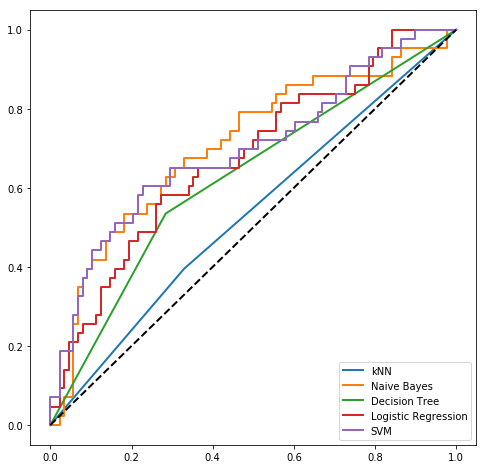

In [20]:
plt.figure(figsize=(8,8))
draw_roc(knn, 'kNN', math_attrs_test, math_labels_test)
draw_roc(gau, 'Naive Bayes', math_attrs_test, math_labels_test)
draw_roc(tr, 'Decision Tree',math_attrs_test, math_labels_test)
draw_roc(log_R, 'Logistic Regression',math_attrs_test, math_labels_test)
draw_roc(mysvm, 'SVM', math_attrs_test, math_labels_test)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')

In [21]:
# Linear Regression
from sklearn.linear_model import LinearRegression

math_results= pd.read_csv("https://raw.githubusercontent.com/dieulien/datamining/master/b_math_result.csv", sep = ',',header=None)
math_results = math_results.iloc[:,1:].values

math_attrs_train, math_attrs_test, math_results_train, math_results_test = train_test_split(math_attrs, math_results, test_size=0.33, random_state=42)


# This creates a LinearRegression object
lm = LinearRegression(n_jobs=1)
lm.fit(math_attrs_train, math_results_train.flatten())

print('Estimated intercept coefficient:', lm.intercept_)
print('Number of coefficients:', len(lm.coef_))


lm.coef_

Estimated intercept coefficient: 15.139343210961032
Number of coefficients: 10


array([ 0.64697627, -0.20782813,  0.24079555, -0.10270713,  0.01096626,
        0.53344019, -0.34967589, -0.05651713,  0.47474941, -0.53795651])

Text(0.5,1,'Actual Score vs Predicted Scores: $Y_i$ vs $\\hat{Y}_i$')

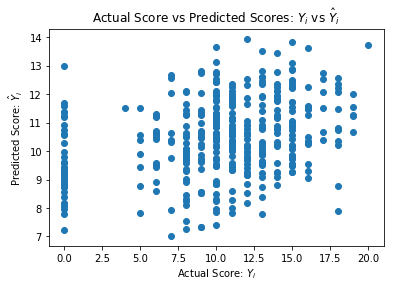

In [22]:
plt.scatter(math_results.flatten(), lm.predict(math_attrs))
plt.xlabel("Actual Score: $Y_i$")
plt.ylabel("Predicted Score: $\hat{Y}_i$")
plt.title("Actual Score vs Predicted Scores: $Y_i$ vs $\hat{Y}_i$")

In [23]:
rss = np.sum((math_results_test.flatten() - lm.predict(math_attrs_test)) ** 2)
mseFull = np.mean((math_results_test.flatten() - lm.predict(math_attrs_test)) ** 2)

print("Residual Sum of Squares = RSS = "+ str(rss))
print("Mean Squared Error = MSE = "+ str(mseFull))

Residual Sum of Squares = RSS = 2572.6882524298026
Mean Squared Error = MSE = 19.638841621601546
